# Visualización del proceso de aprendizaje en Regresión Logística 1D con descenso de gradiente

Nota: La visualización solo funciona en un entorno Jupyter local (no en google colab)

Funciones auxiliares (solo ejecutar, y seguir más abajo)

In [1]:
###############################################################################
%matplotlib notebook

!pip install -q rnutil
import rnutil

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import matplotlib.patches as patches
from collections import namedtuple
from matplotlib import cm

PlotState = namedtuple('PlotState', ['figure','axes','legends'])
OptimalModel = namedtuple('Model', ['m', 'b','error'])

def optimal_model(x,y):
    from sklearn import datasets, linear_model
    regr = linear_model.LogisticRegression(C=1)
    regr.fit(x.reshape(-1, 1),y)
    optimal_m=regr.coef_[0][0]
    optimal_b=regr.intercept_[0]
    optimal_yhat = forward(x,optimal_m,optimal_b)
    optimal_error=mean_binary_cross_entropy(y,optimal_yhat)
    return OptimalModel(optimal_m,optimal_b,optimal_error)


def sigmoid(x):
    return 1/(1+np.exp(-x))
def linear(x,m,b):
    return x*m+b

def forward(x,m,b):
    return sigmoid(linear(x,m,b))

def mean_binary_cross_entropy(y,yhat):
    eps = np.finfo(float).eps
    n=len(y)
    errors=np.zeros(n)
    for i in range(n):
        if y[i]==1:
            errors[i]=-np.log(yhat[i]+eps)# agregamos un valor chico por si yhat[i]=0
        else: #y[i]==0
            errors[i]=-np.log(1-yhat[i]+eps)
            
    # implementación vectorial
    #errors=y* (-log(yhat)) +(1-y)* (-log(-yhat))
    return errors.mean()
    

def backward(x,y,m,b):
    dEdm=0
    dEdb=0
    n=len(x)
    fx=forward(x,m,b)
    for i in range(n):
        dEdmi=(fx[i]-y[i])*x[i]
        dEdm+=dEdmi
        dEdbi=(fx[i]-y[i])
        dEdb+=dEdbi
    return dEdm,dEdb

def visualizar_modelo(ax_data,x,m,b):
    x_pad=70
    min_x,max_x=x.min()-x_pad,x.max()+x_pad
    x_plot=np.linspace(min_x,max_x,40)
    y_plot=forward(x_plot,m,b)
    ax_data.plot(x_plot,y_plot,'-',color="red")
    
def init_data(ax_data,x,y,optimal,m,b):
    ax_data.scatter(x,y,color="blue")
    
    visualizar_modelo(ax_data,x,optimal.m,optimal.b)
    
    ax_data.set_xlabel("x (Horas estudiadas)")
    ax_data.set_ylabel("y p(aprobar | x)")
    
def init_error_history(ax_error):
    ax_error.set_xlabel("Iteración")
    ax_error.set_ylabel("Error")
    ax_error.set_title("Historial de Error")
    
def init_contour(ax_contour,x,y,optimal,m,b):    
    ax_contour.set_xlabel("m")
    ax_contour.set_ylabel("b")
    ax_contour.set_title("Contorno de E(m,b) ")
    
    samples=100
    param_range=6
    M = np.linspace(-param_range, param_range, samples)
    B = np.linspace(-param_range, param_range, samples)    
    ms, bs = np.meshgrid(M, B)
    
    es=np.zeros_like(ms)
    n_m=ms.shape[0]
    n_b=ms.shape[0]
    
    for i in range(n_m):
        for j in range(n_b):
            y_hat = forward(x,ms[i,j],bs[i,j])
            es[i,j]=mean_binary_cross_entropy(y,y_hat)

    surf=ax_contour.contourf(ms,bs,es,cmap='coolwarm')
    
    ax_contour.scatter([optimal.m], [optimal.b],c="green")
    plt.colorbar(surf, shrink=0.5, aspect=5)
    
def init_plot(x,y,optimal,m,b):
    
    figure=plt.figure(dpi=100,figsize=(14,6))
    plt.suptitle('Entrenamiento de modelo logístico')
    ax_data=figure.add_subplot(1,3,1)
    ax_error=figure.add_subplot(1,3,2)
    ax_contour=figure.add_subplot(1,3,3)#,projection='3d')
    axes=(ax_data,ax_error,ax_contour)
    
    init_data(ax_data,x,y,optimal,m,b)
    init_error_history(ax_error)
    init_contour(ax_contour,x,y,optimal,m,b)

    return PlotState(figure,axes,None)

def visualizar(plot_state,x,y,iteration,m,b,dEdm,dEdb,optimal,max_iterations,error_history):
    (ax1,ax2,ax3)=plot_state.axes
    # Visualizacion
    
    #actualizar linea del modelo actual
    ax1.lines.pop()
    visualizar_modelo(ax1,x,m,b)
#     ax3.scatter(iteration_state.m, iteration_state.b, iteration_state.mean_error,c="black",s=50)
    ax3.scatter([m], [b],c="black",s=5)
    
    # Mostrar leyendas
    model = patches.Patch(color='red', label='Modelo: y=$\\sigma$(x*({:.2f})+({:.2f}))'.format(m,b))
    label='Modelo de sklearn: y=$\\sigma$(x*({:.2f})+({:.2f}))'.format(optimal.m,optimal.b)
    model_true = patches.Patch(color='cyan', label=label)
    label='$\\frac{ \\partial E}{\\partial m}=$ %.2f, $\\frac{ \\partial E}{\\partial b}$ %.2f' %(dEdm,dEdb)
    derivatives = patches.Patch(color='red', label=label)
    error_patch = patches.Patch(color='red', label='$E=\\frac{1}{n} \sum_i^n E_i=$ %.2f' % (error_history[-1]))
    optimal_error = patches.Patch(color='cyan', label='E del modelo de sklearn: %.2f' % (optimal.error))
    handles=[model,model_true,derivatives,error_patch,optimal_error]
    
    ax2.lines.clear()
    ax2.plot(error_history)
    ax2.set_xlim(0,max_iterations)
    miny,maxy=ax2.get_ylim()
    ax2.set_ylim(0,maxy)
    ax2.set_title("Curva de error de entrenamiento")
    ax2.legend(handles=handles)
    
    ax1.set_title("Iteración %03d / %03d" % (iteration+1,max_iterations))
    
    plot_state.figure.canvas.draw()
        
    

###############################################################################


rnutil: Los archivos de los conjuntos de datos que ofrece este paquete también están disponibles en https://github.com/facundoq/redes-neuronales-util/tree/main/rnutil/data para descargar de forma individual
rnutil: Agregando el parámetro local=True en las funciones rnutil.load_dataset_numpy, rnutil.load_dataset_pandas y rnutil.load_image se puede cargar una versión local de un archivo en lugar de la versión que ofrece este paquete.


# Visualización del modelo y la superficie del error durante el aprendizaje

El siguiente código entrena un modelo de regresión logistica 1D `f(x)=sigmoid(mx+b)` con descenso de gradiente.

Para eso se muestran 3 gráficos durante la optimización:
* Los datos y el modelo, con los valores del error medio y las derivadas de los parámetros.
* La curva de error, que indica el error del modelo para cada iteración del algoritmo
* La superficie del error, que en este caso se muestra como el _contorno_ del error, es decir, como la superficie del error vista de arriba, y utilizando colores para indicar los valores del error.

Estos gráficos se actualizan en cada iteración del algoritmo, de modo de poder ver el recorrido de los valores `m` y `b`, como eso afecta al modelo, y como va minimizándose el error en consecuencia.

Probá modificando:
* Los valores iniciales de los parámetros `m` y `b`
* La tasa de aprendizaje `α`
* La cantidad de iteraciones máximas `max_iterations`

Y comprendiendo como estos valores inciden en el algoritmo. Respondé:

* ¿Qué valores de `α` permiten que el algoritmo converja? ¿y cuales que converja en un tiempo razonable?
* ¿Se alcanza siempre el mínimo global (punto verde)?
* ¿Qué parámetro importa más para la optimización? La magnitud de las derivadas ¿es la misma para ambos?
* ¿Se avanza lo mismo en todas las iteraciones (relacionar con magnitud de derivadas)?


Luego de eso, entre el comentario `## COMIENZO NORMALIZAR` y `##FIN NORMALIZAR`, normalizá los datos de entrada `x` restándoles la media μ y dividiendo por la desviación estándar σ con la fórmula `x ← (x-μ)/σ`. Recordá que `x` es un vector de NumPy y por ende soporta los métodos `mean()` y `std()`. 

Volvé a responder las preguntas anteriores ahora con los datos normalizados.

Loading file from package rnutil (/home/adrian/.conda/envs/rn/lib/python3.10/site-packages/rnutil/data)...
Done


<IPython.core.display.Javascript object>


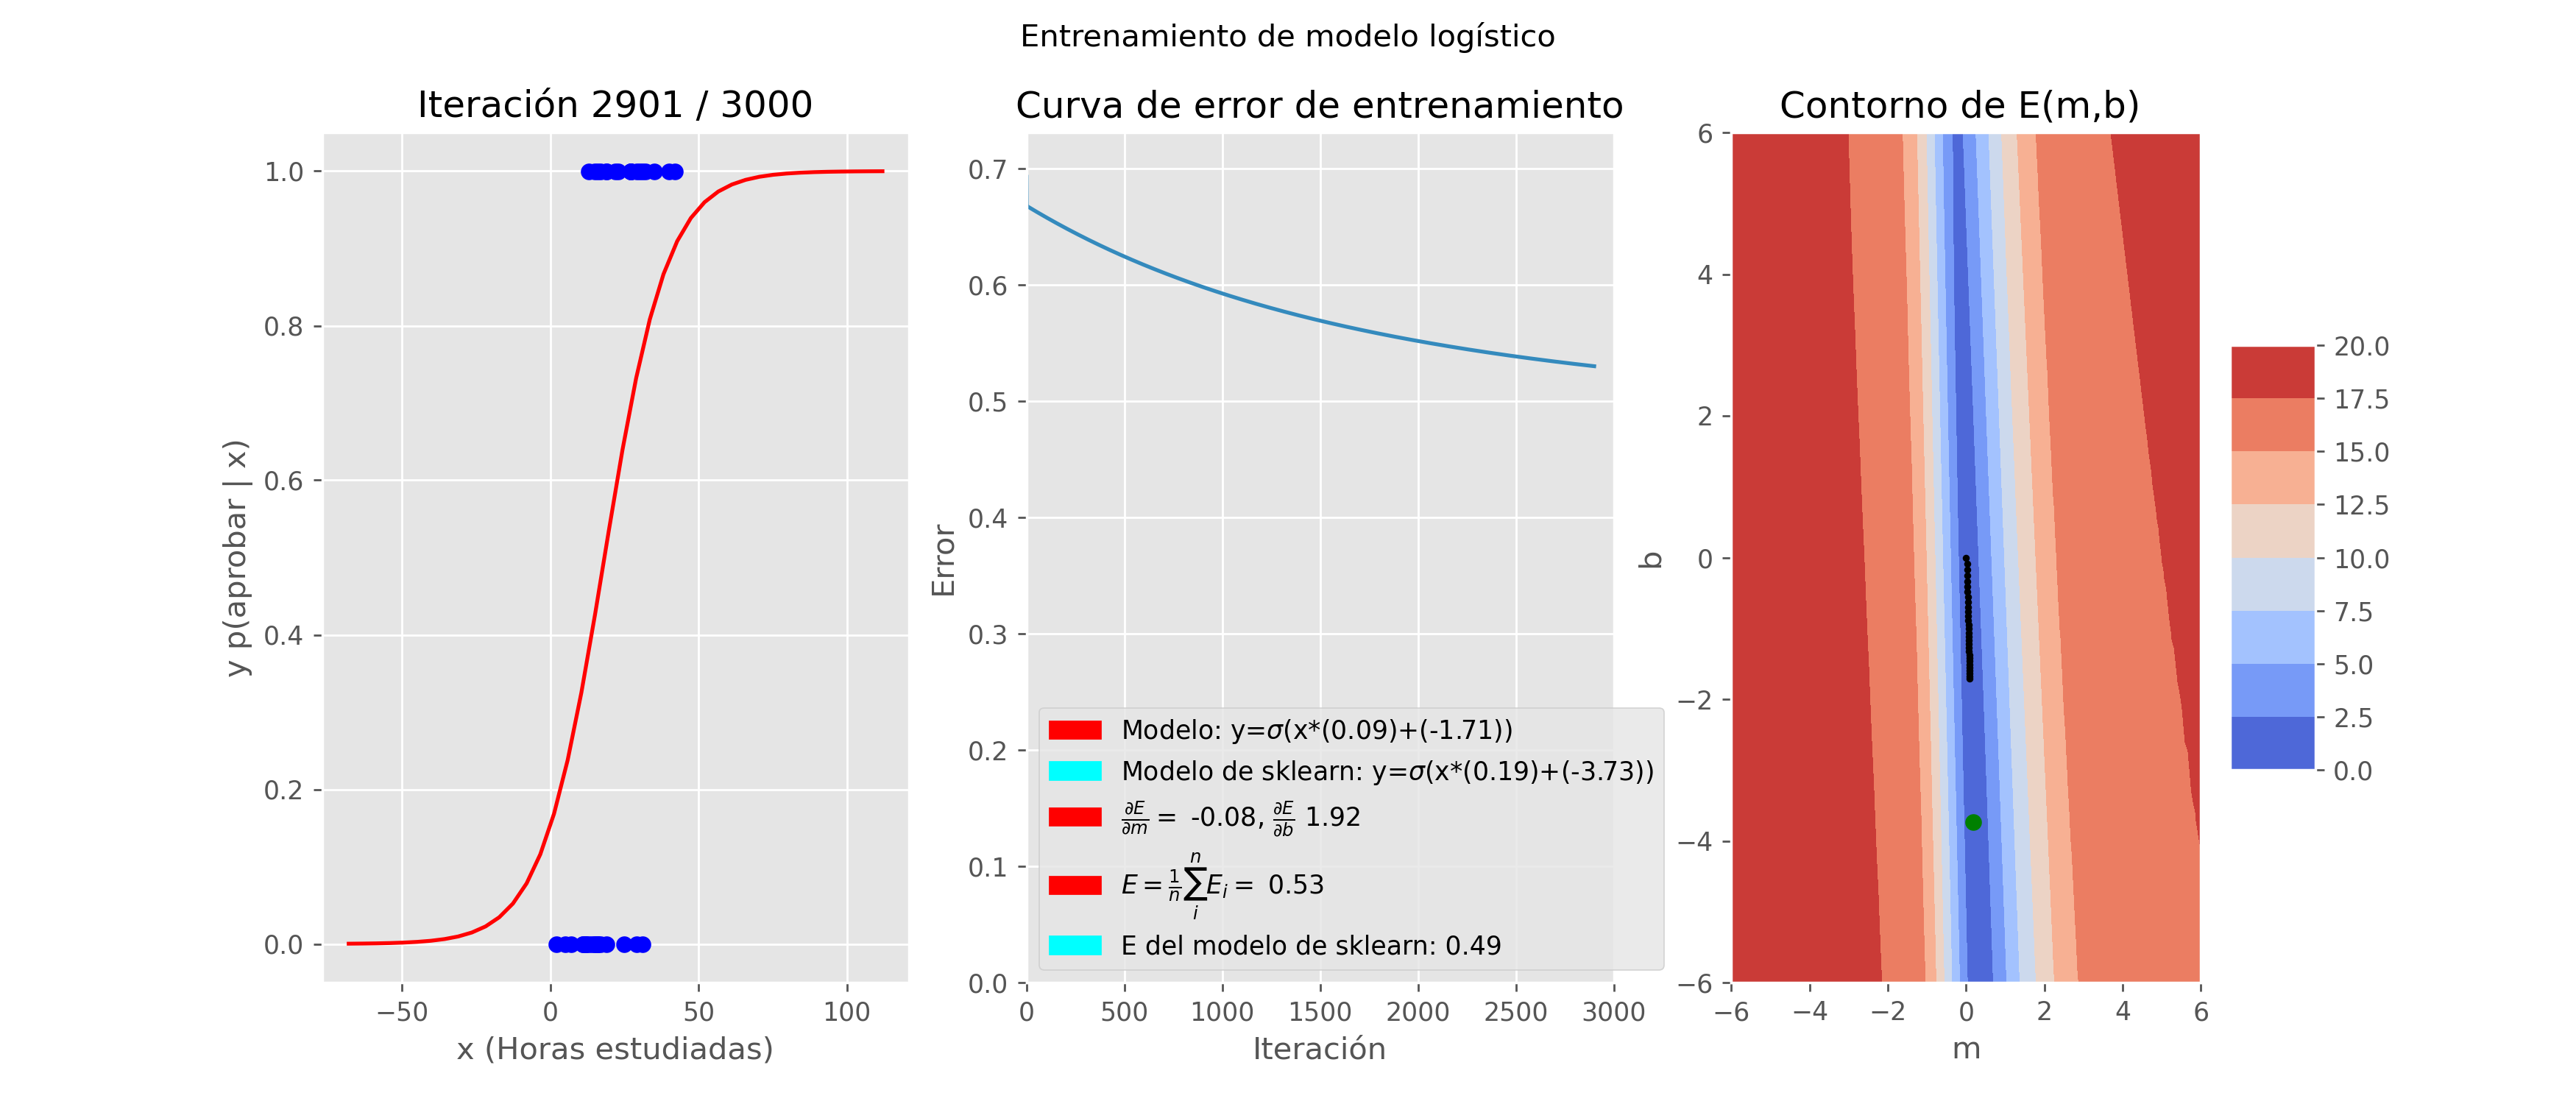

/var/tmp/ipykernel_1240387/391100731.py:107: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(surf, shrink=0.5, aspect=5)


In [2]:
## Carga de datos
data = rnutil.load_dataset_numpy("study_logistic.csv")
x,y=data[:,0],data[:,1]


## Parámetros iniciales del modelo (probar valores entre -5 y 5)
m=0
b=0
# Configuración del descenso de gradiente

#iteraciones máximas a realizar
max_iterations=3000
#velocidad de aprendizaje
#valores sensatos: entre 0.00001 y 0.001
alpha=0.0002
#fin Configuración

# Cálculo del valor óptimo por sklearn
optimal=optimal_model(x,y)
# fin cálculo del valor óptimo por sklearn

# Inicialización del algoritmo
iteration=0
mean_error=0
error_history=[]
# Fin inicialización del algoritmo

# Opciones de visualización 

fps=30
#Fin opciones de visualización
plot_state=init_plot(x,y,optimal,m,b)
error_history=[]

while iteration<max_iterations:
    
    #DESCENSO DE GRADIENTE

    #calculo de derivadas
    dEdm,dEdb=backward(x,y,m,b)
   
    #CALCULO DE ERROR
    #Calculo del error del modelo
    yhat=forward(x,m,b)
    error = mean_binary_cross_entropy(y,yhat)
    error_history.append(error)
    #FIN CALCULO DE ERROR
    
    #visualización
    if (iteration % 100 ==0):
        visualizar(plot_state,x,y,iteration,m,b,dEdm,dEdb,optimal,max_iterations,error_history)
        plt.pause(1/fps)
    # fin visualización
    
    #actualizo los parámetros
    m=m-alpha*dEdm
    b=b-alpha*dEdb
    # FIN DESCENSO DE GRADIENTE
    
    iteration+=1